In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
raw_df = pd.read_csv('creditcard.csv')

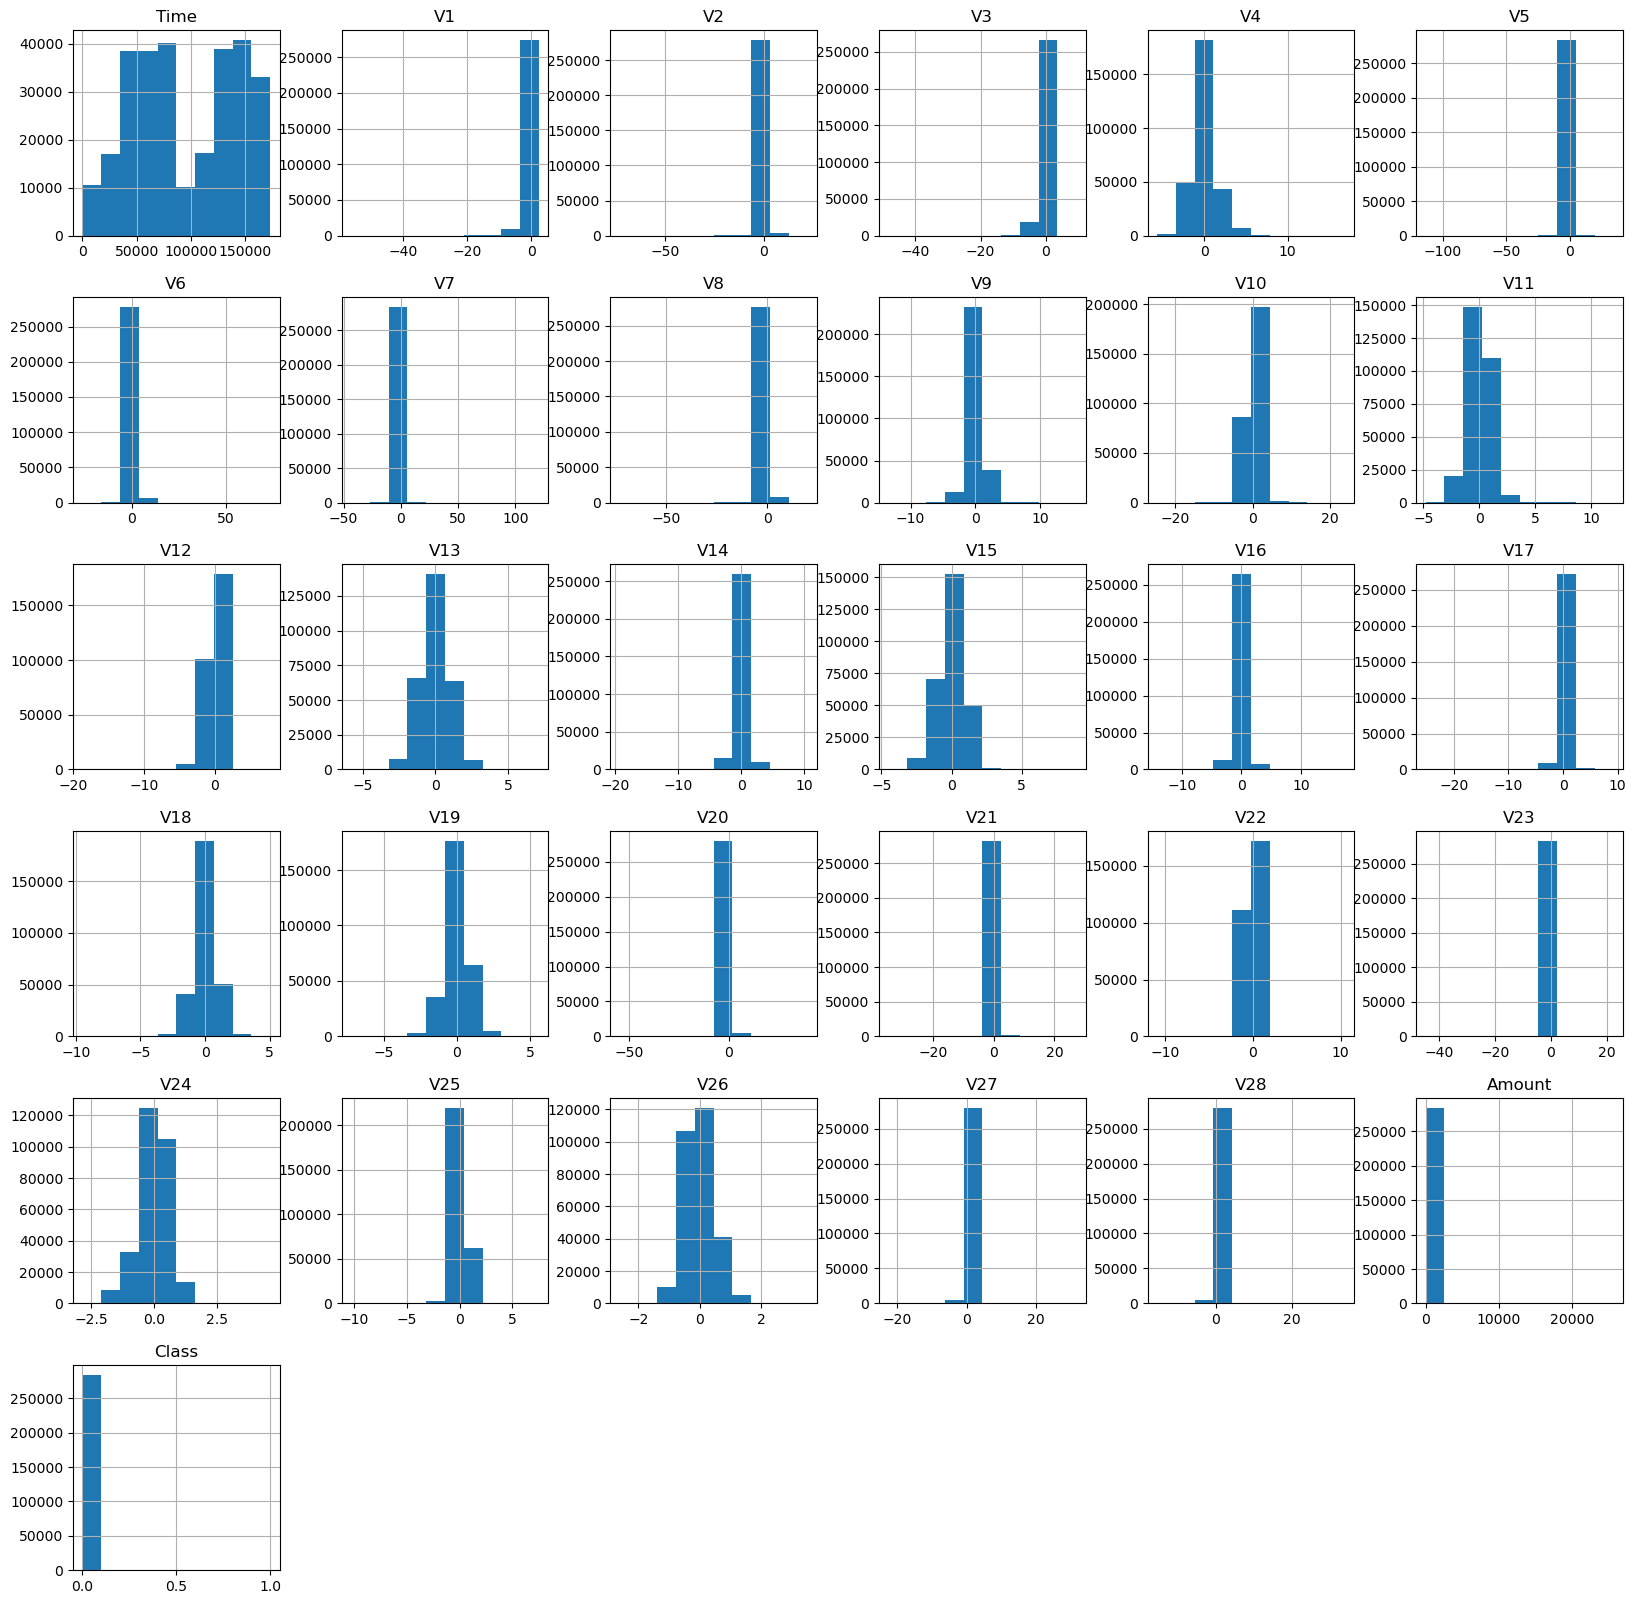

In [3]:
raw_df.hist(figsize=(20, 20), bins=10)
plt.show()

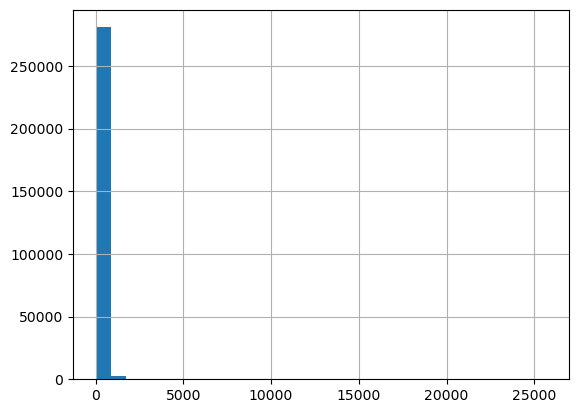

In [4]:
# 피처 Amount가 매우 불균형
raw_df['Amount'].hist(bins=30)
plt.show()

In [5]:
# 혹시 모르니 복사본으로 만든다.
df = raw_df.copy()

### 피처 데이터를 표준 정규 분포로 변환(mean=0, standard deviation=1) 

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df['Amount'].to_numpy().reshape(-1, 1))
amount_scaled = scaler.transform(df['Amount'].to_numpy().reshape(-1, 1))

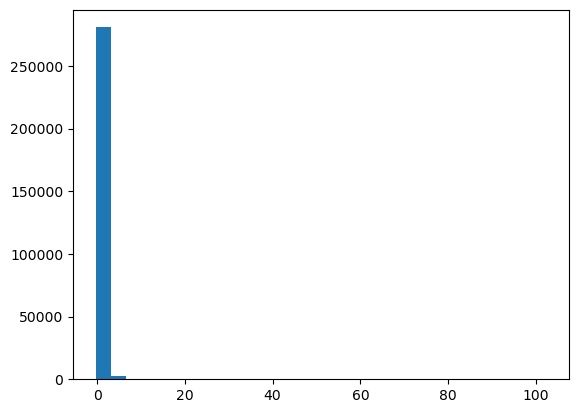

In [7]:
plt.hist(amount_scaled, bins=30)
plt.show()

### 피처 데이터를 로그 변환(Log Transformation) : 정규 분포 근사
##### 불균형 피처 데이터에 적용한다.

In [8]:
amount_log = np.log1p(df['Amount'])

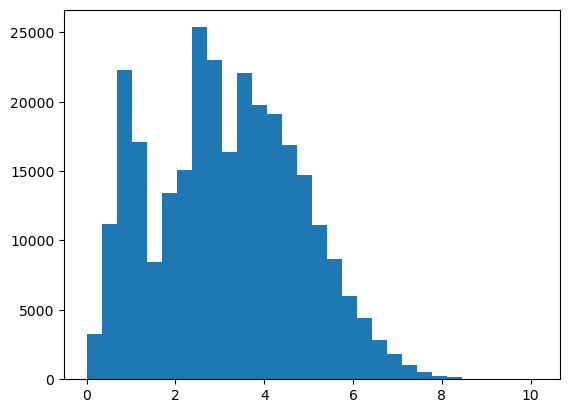

In [9]:
plt.hist(amount_log, bins=30)
plt.show()

In [10]:
# 로그 변환된 피처 데이터 등록
df['Amount_log_transformed'] = np.log1p(df['Amount'])

In [11]:
# 기존 불균형 피처 데이터 삭제
df.drop('Amount', axis=1, inplace=True)

In [12]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'Amount_log_transformed'],
      dtype='object')

### 로그 변환된 데이터로 다시 로지스틱 회귀로 학습

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_features = df.drop(['Class', 'Time'], axis=1)
y_label = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, stratify=y_label)

log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = log_reg.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred):.2f}')

정밀도(precision) : 0.89
재현율(recall) : 0.55
F1 점수 : 0.68


##### 데이터 증강(Data Augmentation)
##### Under Sampling : 정상 데이터를 줄인다.
##### Over Sampling : 사기 데이터를 늘린다.
##### 일반적으로 Over Sampling이 좋다.

In [15]:
# SMOTE 오버 샘플링
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=5)
X_train_augmented, y_train_augmented = smote.fit_resample(X_train, y_train)

In [16]:
y_train_augmented.value_counts()

0    227451
1    227451
Name: Class, dtype: int64

In [17]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train_augmented, y_train_augmented)

LogisticRegression(max_iter=5000)

In [18]:
y_pred = log_reg.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred):.2f}')

정밀도(precision) : 0.06
재현율(recall) : 0.92
F1 점수 : 0.11


### 재현율은 90%를 넘었지만 정밀도는 아주 절망적...
##### 재현율과 정밀도의 조화 평균인 F1 점수가 낮다는 것은 한쪽에 치우쳤다는 것

In [19]:
# 앙상블 학습 중 같은 종류의 classifier를 활용한 Bagging 방식의 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, max_depth=5)
random_forest.fit(X_train_augmented, y_train_augmented)

RandomForestClassifier(max_depth=5)

In [20]:
y_pred = random_forest.predict(X_test)

print(f'정밀도(precision) : {precision_score(y_test, y_pred):.2f}')
print(f'재현율(recall) : {recall_score(y_test, y_pred):.2f}')
print(f'F1 점수 : {f1_score(y_test, y_pred):.2f}')

정밀도(precision) : 0.31
재현율(recall) : 0.86
F1 점수 : 0.46
